# Task 1 - Gun violence dataset analysis

Antoni Blachnicki - 258332 (223931)
### OLEK UZUPEŁNIJ SWÓJ NUMER PLS
Aleksander Cholewiński - 258 (223104)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
gun_data = pd.read_excel('Task1/gun_violence_data_2013_2018.xlsx')

## 1. Which state has the most murders?


In [3]:
murders = gun_data['state'].where(gun_data['n_killed'] > 0).value_counts() #where at least 1 person was killed; sort alphabetically
print(f"Highest murders: {murders.index[0]} - {murders.iloc[0]}")

Highest murders: California - 4972


In [4]:
import requests
import bs4
req = requests.get("https://www.statsamerica.org/sip/rank_list.aspx?rank_label=pop1")
statePopDict={}
if req.status_code == 200:
    soup = bs4.BeautifulSoup(req.text, 'html.parser')
    table = soup.find_all('table')[0]
    rows = table.find_all('tr')
    for row in rows[1:]:
        cells = row.find_all('td')
        statePopDict[cells[1].text.strip()] = int(cells[3].text.strip().replace(',',''))
else:
    print(f"Request failed with status {req.status_code}")

## 2. Murder count per 100k population per state

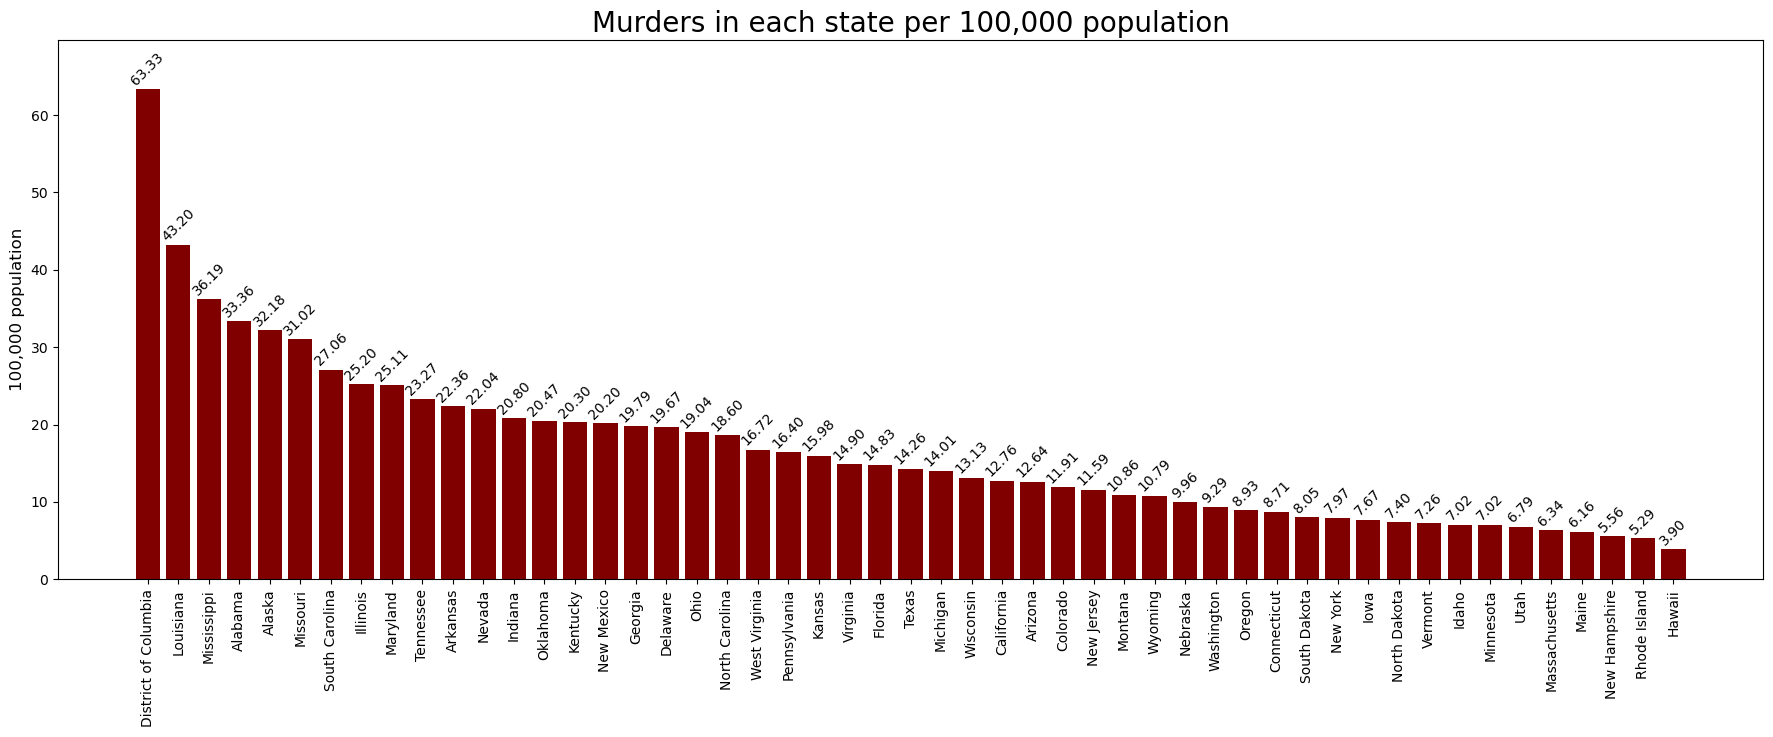

In [5]:
#population @2023 source: https://www.statsamerica.org/sip/rank_list.aspx?rank_label=pop1
#todo: change to 2023 data
    
murders = murders.sort_index() 
popDict = statePopDict
murDict = {}
for i in murders.to_dict().keys():
    murDict[i] = murders[i]

#NOTE: scaling down to 'per 100,000' because the scale is awful otherwise

per100Dict = {}
for k in murDict:
    #todo: try to use dict comprehension
    per100Dict[k] = murDict[k]/(int(popDict[k])/100000)
    # print('state:', k, '; population:', popDict[k], '; murders:', murDict[k], ';murders per 100k', (murDict[k]/(popDict[k]/100000)))
# moved to another var separate to sort by value descending
per100DictSortedValues = dict(sorted(per100Dict.items(), key=lambda x:x[1], reverse=True))

plt.figure(figsize=(22, 7))
plt.title('Murders in each state per 100,000 population').set_size(20)
barplt = plt.bar(per100DictSortedValues.keys(), per100DictSortedValues.values(), color ='maroon', 
        width = .8)
plt.bar_label(barplt,fmt='%.2f', rotation=45, padding=1, size=10)
plt.ylabel('100,000 population', size=12)
plt.margins(y=0.1)
plt.xticks(rotation=90);

In [6]:
print(f"Highest murder per 100,000 population: {list(per100DictSortedValues)[0]} with {per100DictSortedValues[list(per100DictSortedValues)[0]]:.2f} murders. Overall murders for {list(per100DictSortedValues)[0]}: {murDict[list(per100DictSortedValues)[0]]}")
print(f"California has {per100DictSortedValues['California']:.2f} murders per 100,000 people. Total number of murders in California: {murDict['California']}")

Highest murder per 100,000 population: District of Columbia with 63.33 murders. Overall murders for District of Columbia: 430
California has 12.76 murders per 100,000 people. Total number of murders in California: 4972


As is visible, despite California leading in the amount of murders (gun violence reports with `n_killed` > 0) the per capita amount of murders is almost 5 times lower than in District of Columbia.

In [7]:
#todo: make a list of total gun accident counts where n_killed+n_injured >= 1

## 3. New dataset creation

In [8]:
with open('Task1/new_dataset.csv', 'w') as new_data:
    new_data.write("state,population,murders_total,murder_rate\n")
    for k in murDict:
        new_data.write(f"{k},{popDict[k]},{murDict[k]},{per100Dict[k]}\n")

## 4. Distribution of murders across states

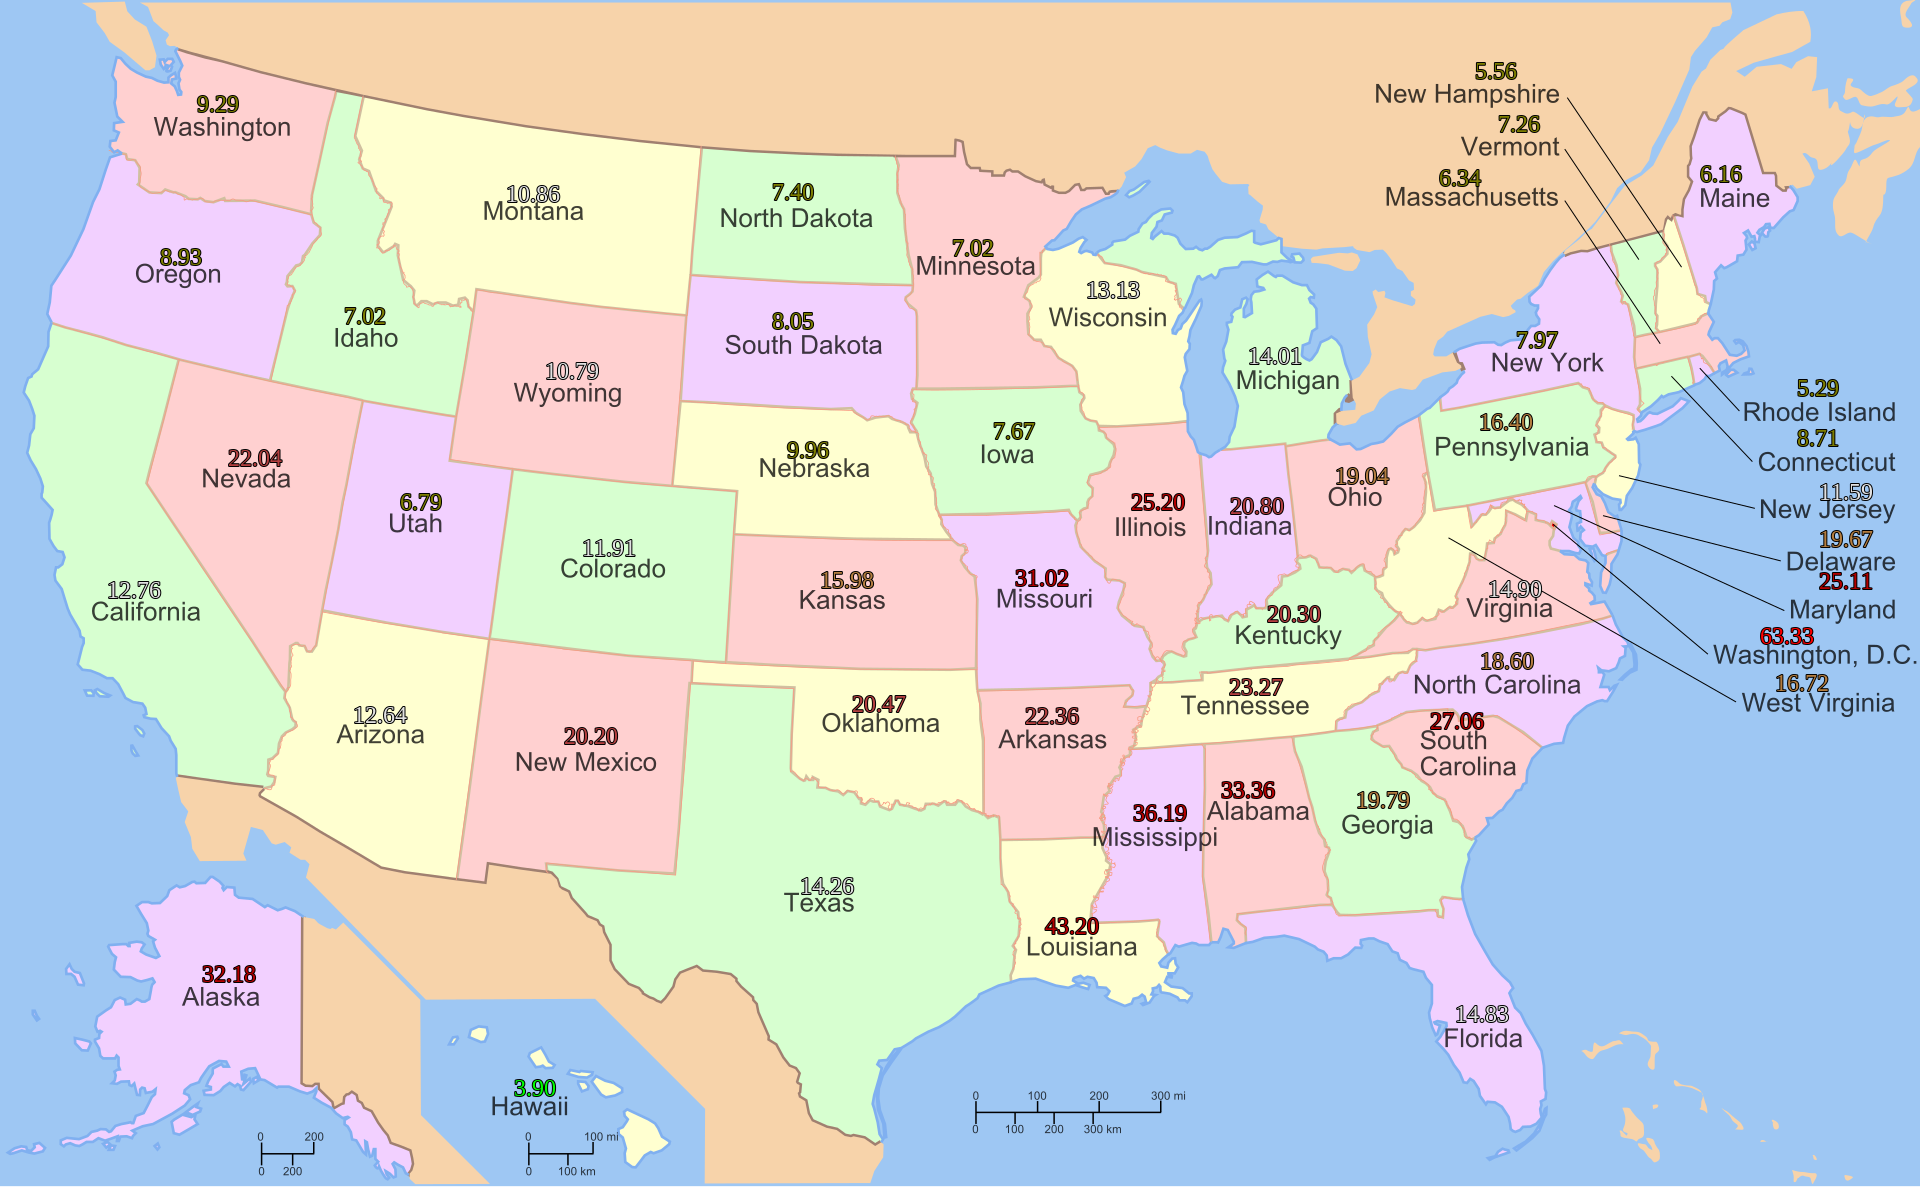

In [77]:
from PIL import Image, ImageFont, ImageDraw
from ast import literal_eval
img = Image.open('Task1/usa_map.png')  # Source: https://upload.wikimedia.org/wikipedia/commons/9/92/Map_of_USA_with_state_names_2.svg

drawing = ImageDraw.Draw(img)
from matplotlib import font_manager
system_fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
myFont = ImageFont.truetype('LiberationSerif-Regular.ttf', 24)

with open('Task1/coords.csv') as coords:
    while line := coords.readline():
        k, coord = line.split('|')
        coord = list(literal_eval(coord)) #tuple cannot be changed
        coord[1] -= 18 #move all text draws upwards
        coord = tuple(coord)
        colors = {'<5': (0,255,0),'5-10':(125,125,0), '10-15': (225,225,225), '15-20':(180,125,63),'20-25':(180,63,63),'>25':(180,0,0)}
        val = per100Dict[k]
        if val < 5.0:
            clr = colors['<5']
        elif val >= 5.0 and val < 10.0:
            clr = colors['5-10']
        elif val >= 10.0 and val < 15.0:
            clr = colors['10-15'] 
        elif val >= 15.0 and val < 20.0:
            clr = colors['15-20']
        elif val >= 20.0 and val < 25.0:
            clr = colors['20-25']
        elif val < 60:
            clr = colors['>25']
        else:
            clr = (255,0,0)
        drawing.text(coord, f"{per100Dict[k]:.2f}", font=myFont, fill=clr, stroke_width=1, stroke_fill='black')
display(img);